In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import random
from torch.nn import functional as F
import pandas as  pd
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 93347383.84it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64847801.83it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24947933.17it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6670353.21it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda


In [4]:
batch_size = 64
train_dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

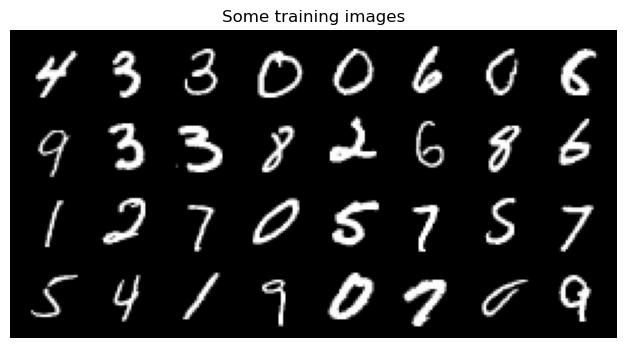

In [7]:
item = next(iter(train_dataloader))
plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Some training images")
plt.imshow(np.transpose(vutils.make_grid(item[0].to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))

In [29]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(784, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, latent_dim * 2), # space for mu and logvar
#             nn.ReLU(),
#             nn.Linear(latent_dim * 2, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim ** 2),
            nn.ReLU(),
            nn.Linear(latent_dim ** 2, 784),
            nn.Sigmoid(),
        )
        
    def reparam_trick(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = std.data.new(std.size()).normal_()
        return z_mean + eps * std
        
    def encode(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.latent_dim)
        mu = mu_logvar[:,0,:]
        logvar = mu_logvar[:,1,:]
        
        return mu, logvar
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam_trick(mu, logvar)
        return self.decode(z), mu, logvar
    

In [30]:
def vae_loss_function(x,y, mu, log_var, kl_weight=1.0):
        reconst_loss = F.binary_cross_entropy(x, y, reduction='sum')
        kl_div_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        
        loss = reconst_loss  + kl_weight * kl_div_loss
        return loss, reconst_loss.detach().item(), kl_weight * kl_div_loss.detach().item()

In [31]:
### A more complex model

# class VAE(nn.Module):
#     def __init__(self, latent_dim, in_channels):
#         super().__init__()
        
#         self.hidden_dim = latent_dim
#         self.original_channels = in_channels
#         hidden_dims = [16, 32, 64, 64]
        
#         ### ENCODER
#         enc_modules = []
#         for h_dim in hidden_dims:
#             enc_modules.append(
#                 nn.Sequential(
#                     nn.Conv2d(in_channels, out_channels=h_dim,
#                               kernel_size= 3, stride= 2, padding  = 1, bias=False),
#                     nn.BatchNorm2d(h_dim),
#                     nn.LeakyReLU())
#             )
#             in_channels = h_dim
#         self.encoder = nn.Sequential(*enc_modules)
#         self.z_mean = nn.Linear(hidden_dims[-1]*4, latent_dim)
#         self.z_log_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        
#         ### DECODER   

#         self.dec_input = nn.Linear(latent_dim, hidden_dims[-1])
#         self.decoder = nn.Sequential(
#             # block 1
#             nn.ConvTranspose2d(64, 64, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 3, 1, 0, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 16, 3, 2, 0, bias=False),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, self.original_channels, 3, 2, 0,output_padding=1, bias=False),
#             nn.BatchNorm2d(self.original_channels),
#             nn.Sigmoid()
#         )
        

#     def encode(self, x):
#         x = self.encoder(x)
#         x = torch.flatten(x, start_dim=1)
        
#         z_mean = self.z_mean(x)
#         z_log_var = self.z_log_var(x)
#         return z_mean, z_log_var
    
#     def decode(self, z):
#         dec_in = self.dec_input(z)
#         dec_in = dec_in.view(-1, 64, 1, 1) # prep for transpose convolution
#         result = self.decoder(dec_in)
#         return result
    
#     def reparam_trick(self, z_mean, z_log_var):
#         std = torch.exp(0.5 * z_log_var)
# #         std = z_log_var
#         eps = torch.randn_like(std)
#         return z_mean + eps * std
    
#     def loss_function(self, x,y, mu, log_var, kl_weight=1.0):
#         reconst_loss = F.mse_loss(x,y)
#         kl_div_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        
#         loss = reconst_loss  + kl_weight * kl_div_loss
#         return loss
        
#     def forward(self,x):
#         z_mean, z_log_var = self.encode(x)
#         z = self.reparam_trick(z_mean, z_log_var)
# #         print('z', z.size())
#         out = self.decode(z)
#         return out, z_mean, z_log_var

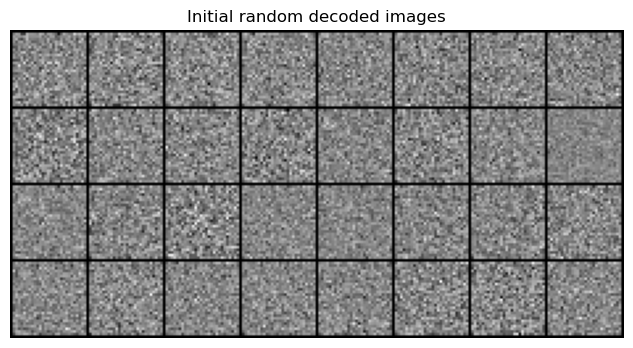

In [32]:
vae = VAE(32)

plt.figure(figsize=(8,4))
plt.axis("off")
plt.title("Initial random decoded images")
plt.imshow(np.transpose(vutils.make_grid(vae(item[0])[0].to(device)[:32], padding=1, normalize=True).cpu(),(1,2,0)))

In [33]:
# def zero_out_image_portion(images, n):
#     batch_size, channels, height, width = images.size()
#     max_row_idx = height - n
#     max_col_idx = width - n
    
#     modified_images = images.clone()
    
#     for image_idx in range(batch_size):
#         row_idx = random.randint(0, max_row_idx)
#         col_idx = random.randint(0, max_col_idx)
        
#         modified_images[image_idx, :, row_idx:row_idx+n, col_idx:col_idx+n] = 1.0
        
#     return modified_images

In [34]:
# items = next(iter(train_dataloader))
# items = zero_out_image_portion(items[0], 8)
# plt.figure(figsize=(8,4))
# plt.axis("off")
# plt.title("Some training images")
# plt.imshow(np.transpose(vutils.make_grid(items.to(device)[:32], padding=4, normalize=True).cpu(),(1,2,0)))

In [35]:
num_GPUs = 2 # change accordingly

model = VAE(latent_dim=12).to(device)
if (device.type == 'cuda') and (num_GPUs > 1):
    model = nn.DataParallel(model, list(range(num_GPUs)))
    print(f'Using {num_GPUs} GPUs')

Using 2 GPUs


In [36]:
max_epochs = 30
lr = 1e-3

beta = 10.0
loss_fn = vae_loss_function
optimizer = optim.Adam(model.parameters(), lr=lr)

In [28]:
losses = []
kld_losses = []
rec_losses = []

for epoch in range(max_epochs):
    for i, data in enumerate(train_dataloader):
        model.zero_grad()
        x = data[0].to(device)
        
        out, mu, log_var = model(x)
        
        loss, rec, kld = loss_fn(out, x, mu, log_var, beta)
        
        if i % 200 == 0:
            print(f'[{epoch}/{max_epochs-1}][{i}/{len(train_dataloader)}]|\t Loss:{loss.item()} [{rec}+{kld}]')
            losses.append(loss.item())
            kld_losses.append(kld)
            rec_losses.append(rec)
        loss.backward()
        optimizer.step()

[0/29][0/938]|	 Loss:35428.80859375 [35427.5546875+1.2521570920944214]
[0/29][200/938]|	 Loss:11517.3583984375 [11193.466796875+323.89190673828125]
[0/29][400/938]|	 Loss:9766.5166015625 [9428.15625+338.3601379394531]
[0/29][600/938]|	 Loss:8989.185546875 [8666.1494140625+323.03600311279297]
[0/29][800/938]|	 Loss:8444.7919921875 [8087.361328125+357.430419921875]
[1/29][0/938]|	 Loss:8518.677734375 [8147.8359375+370.8421325683594]
[1/29][200/938]|	 Loss:6991.06396484375 [6648.6025390625+342.4613952636719]
[1/29][400/938]|	 Loss:6994.91552734375 [6606.43505859375+388.4804153442383]
[1/29][600/938]|	 Loss:7004.59521484375 [6655.177734375+349.41761016845703]
[1/29][800/938]|	 Loss:6740.4765625 [6376.248046875+364.2283248901367]
[2/29][0/938]|	 Loss:7080.296875 [6698.7890625+381.5079116821289]
[2/29][200/938]|	 Loss:6691.23193359375 [6344.24658203125+346.9852066040039]
[2/29][400/938]|	 Loss:6538.5498046875 [6188.533203125+350.01659393310547]
[2/29][600/938]|	 Loss:6096.4267578125 [5732.64

Text(0.5, 1.0, 'Reconstruction loss')

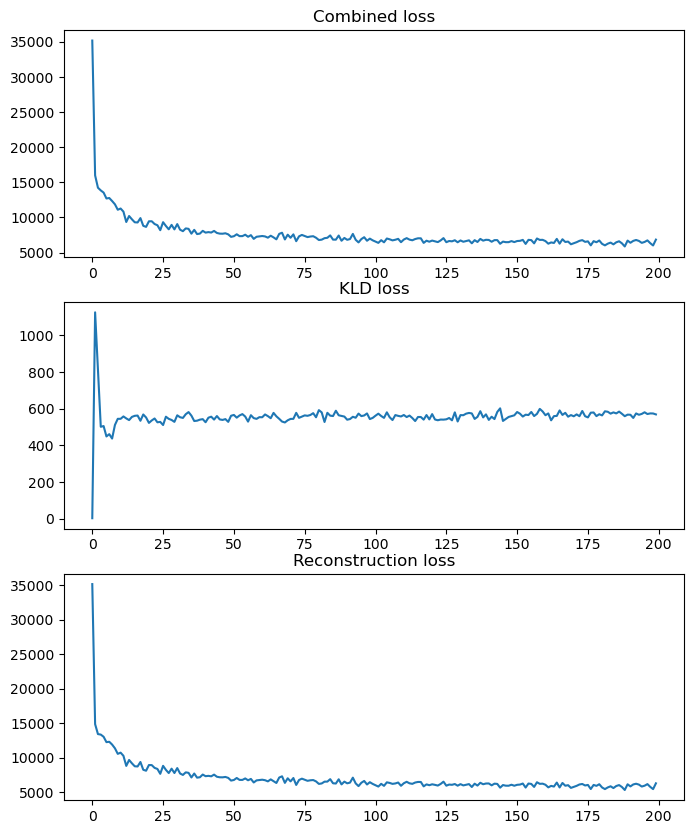

In [18]:
fig, ax = plt.subplots(3,1, figsize=(8, 10))
# fig, ax = plt.subplots(2, figsize=(3, 6))
ax[0].plot(losses)
ax[0].set_title('Combined loss')
ax[1].plot(kld_losses)
ax[1].set_title('KLD loss')
ax[2].plot(rec_losses)
ax[2].set_title('Reconstruction loss')

## Visualize the latent space with t-SNE

In [19]:
from sklearn.manifold import TSNE

mus = None
labels = None
with torch.no_grad():
    for i, data in enumerate(train_dataloader):
        x = data[0].to(device)
        _, mu, _ = model(x)
        if mus is None:
            mus = mu
            labels = data[1]
        else:
            mus = torch.concat((mus, mu), 0)
            labels = torch.concat((labels, data[1]), 0)
        if mus.size()[0] > 5000:
            break

In [20]:
tsne = TSNE(n_components=2).fit_transform(mus.detach().cpu())

In [21]:
df = pd.DataFrame(tsne)
df['label'] = labels.numpy()
df = df.rename(columns={0: "x", 1: "y"})

<Axes: xlabel='x', ylabel='y'>

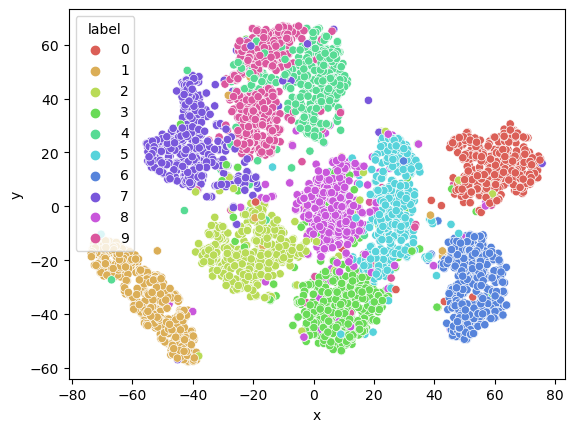

In [23]:
sns.scatterplot(data=df, x='x', y='y', hue='label', palette=sns.color_palette("hls", 10))

## Get examples from random noise in the latent space

torch.Size([32, 1, 28, 28])


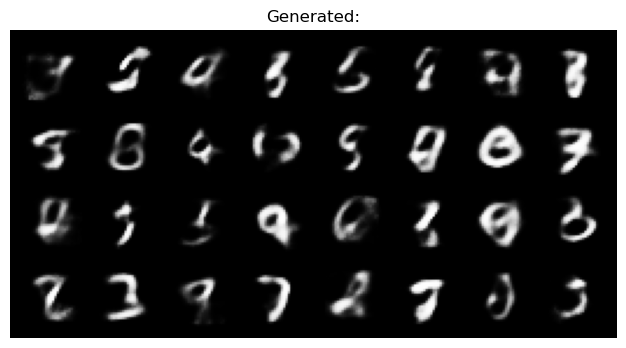

In [25]:
z = torch.randn((32, 16)).to(device)
z.normal_()
samples = None
for i in range(32):
    if samples is None:
        samples = torch.normal(mean=mus.mean(axis=0), std=mus.std(axis=0)).view(1,-1)
    else:
        new_sam = torch.normal(mean=mus.mean(axis=0), std=mus.std(axis=0)).reshape(1,-1)
        samples = torch.concat((samples, new_sam),0)
        

with torch.no_grad():
    if num_GPUs > 1:
        generated = model.module.decode(samples.to(device))
    else:
        generated = model.decode(samples.to(device))
    print(generated.size())
    plt.figure(figsize=(8,4))
    plt.axis("off")
    plt.title("Generated:")
    plt.imshow(np.transpose(vutils.make_grid(generated[:32], padding=4, normalize=True).cpu(),(1,2,0)))

In [60]:
# samples.size()

## Get reconstructed examples

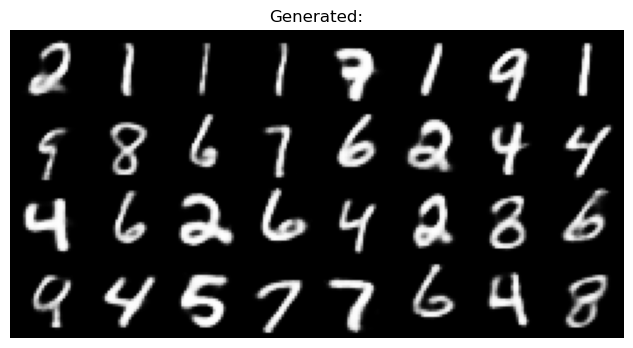

In [61]:
with torch.no_grad():
    out = model(item[0].to(device))[0]
    plt.figure(figsize=(8,4))
    plt.axis("off")
    plt.title("Generated:")
    plt.imshow(np.transpose(vutils.make_grid(out[:32], padding=1, normalize=True).cpu(),(1,2,0)))

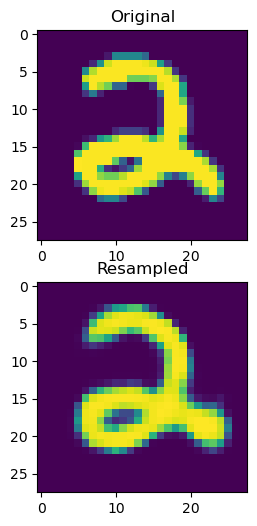

In [63]:
with torch.no_grad():
    
    elem = 18
    fig, ax = plt.subplots(2, figsize=(3, 6))
    ax[0].imshow(np.transpose(item[0][elem],(1,2,0)).view(28,28))
    ax[0].set_title('Original')

    _, mu, logvar = model(item[0])

    if num_GPUs > 1:
#         z = model.module.reparam_trick(mu, logvar)

        z = torch.normal(mean=mu[elem], std=torch.sqrt(torch.exp(logvar[elem]))) 
        z = z.view(1,-1)
        sample = model.module.decode(z).to('cpu')[0]
    else:
        z = torch.normal(mean=mu[elem], std=torch.sqrt(torch.exp(logvar[elem]))) 
        z = z.view(1,-1)
        sample = model.decode(z).to('cpu')[0]
    ax[1].imshow(np.transpose(sample,(1,2,0)).view(28,28))
    ax[1].set_title('Resampled')